<a href="https://colab.research.google.com/github/Aravind-98/Summer_Internship_2020/blob/master/Trial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))   

Saving Price_All.csv to Price_All.csv
User uploaded file "Price_All.csv" with length 1527571 bytes


In [3]:
!pip install pmdarima
!pip install pyramid-arima
!pip install pingouin
!pip install statsmodels

     |████████████████████████████████| 1.5MB 2.8MB/s 
     |████████████████████████████████| 8.7MB 17.5MB/s 
     |████████████████████████████████| 2.1MB 40.8MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.20
    Uninstalling Cython-0.29.20:
      Successfully uninstalled Cython-0.29.20
     |████████████████████████████████| 604kB 2.8MB/s 
     |████████████████████████████████| 225kB 2.8MB/s 
  Created wheel for pingouin: filename=pingouin-0.3.6-cp36-none-any.whl size=217880 sha256=cad26ce7d3396da1bc7a1074622ab06c4b748a00300afb38b38427a3fcee32f0
  Stored in directory: /root/.cache/pip/wheels/0f/12/3e/c50f18f38eaf437b927b567ac6615215fdf75fe58890d32276
  Created wheel for outdated: filename=outdated-0.2.0-cp36-none-any.whl size=4962 sha256=e29c9bc2ea262206379d555738c1a08aefd1c263debbfaf6eeaf71eb5a43a91d
  Stored in directory: /root/.cache/pip/whee

In [4]:
# Import all nesecessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import pingouin as pg
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import LSTM, Dropout, SimpleRNN, GRU, Dense, RepeatVector, TimeDistributed
from keras.utils import plot_model
from keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import keras
from pmdarima.arima import ndiffs
import pmdarima as pm
import scipy.stats as stats

Using TensorFlow backend.


In [5]:
def load_data(filename):
    df=pd.read_csv(filename)
    df.dropna(inplace=True)
    df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df.index = df['Date']
    df=df[df.columns[1:]]
    return df

def rolling_pc(df,window):
    new_data=[]
    columns=list(df.columns)
    for i in range(int(len(df)-window/window)+1):
        extract=data[window*i:window*(i+1)]
        pcorr_vec=[]
        print("~"*5+str(i)+"~"*5)
        for j in range(len(data.columns)-1):
            covar=list(set(columns[:-1]).difference({columns[j]}))
            #print("   "+columns[j]+" "+columns[-1])
            p_cor=pg.partial_corr(data=extract, x=columns[j], y=columns[-1], covar=covar, method='pearson').round(3)
            pcorr_vec.append(float(p_cor["r"]))
        new_data.append(pcorr_vec)
    PCor_dataset=pd.DataFrame(np.array(new_data),columns=data.columns[:-1])
    return PCor_dataset


In [ ]:
df = load_data("Price_All.csv")
data=df[:450]
pre_ARIMA_data=rolling_pc(data,30)

~~~~~0~~~~~
~~~~~1~~~~~
~~~~~2~~~~~


In [1]:
pre_ARIMA_data.describe()

NameError: ignored

In [ ]:
def get_residuals(df,in_sample=True):
    forecast=[]
    residuals=[]
    for i in range(len(df.columns)):
        data=df[df.columns[i]]
        kpss_diffs = ndiffs(data, alpha=0.01, test='kpss', max_d=2)
        adf_diffs = ndiffs(data, alpha=0.01, test='adf', max_d=2)
        n_diffs = max(adf_diffs, kpss_diffs)

        #print(f"Estimated differencing term: {n_diffs}")
        model = pm.auto_arima(data, d=n_diffs, seasonal=False, stepwise=True, suppress_warnings=True, error_action="ignore", max_p=6, max_order=None, trace=False)
        print(f"{df.columns[i]}   :::::   ARIMA model order:{model.order}")
        pred = list(model.predict_in_sample())
        resid=list(data-pred)
        residuals.append(resid) 
        if in_sample==False:
            fcast=model.predict(1)
            forecast.append(fcast) 
    Residuals=pd.DataFrame(np.around(np.array(residuals).T,3),columns=df.columns) 
    return Residuals,forecast   

def train_dev_split(pre_ARIMA_data, window_size, split_ratio=0.5):
    D=[]
    for i in range(len(pre_ARIMA_data.index)-window_size):
        #could probably store just arrays
        d=pd.DataFrame(np.array(pre_ARIMA_data.iloc[i:i+window_size+1].copy()),columns=pre_ARIMA_data.columns)
        r,_=get_residuals(d)
        D.append(r)
        print(f"   ~~ Iteration:{i+1} ~~")

    X={}
    y={}
    u=[]
    v=[]
    for i in range(len(D)):
        u.append(np.array(D[i].iloc[:-1].copy()))
        v.append(np.array(D[i].iloc[-1].copy()))
    X_arr=np.array(u)
    y_arr=np.array(v)  

    s=int(split_ratio*X_arr.shape[0])

    X["train"]=X_arr[:s,:,:]
    X["dev"]=X_arr[s:,:,:]
    y["train"]=y_arr[:s,:]  
    y["dev"]=y_arr[s:,:]


    test=pd.DataFrame(np.array(pre_ARIMA_data.iloc[-window_size:].copy()),columns=pre_ARIMA_data.columns)
    X["test"],forecast=get_residuals(test,False)
    X["test"]=np.expand_dims(X["test"],axis=0)
    ARIMA_forecast=np.reshape(np.array(forecast),(-1,))
    y["ARIMA forecast"]=ARIMA_forecast

    print(f"X's shape:{X_arr.shape}   y's shape:{y_arr.shape}") 
    #print(X["train"].shape y["train"].shape})
    #print(f"X dev's shape:{X["dev"].shape}   y dev's shape:{y["dev"].shape}")
    return X,y    

def plot_residual_distribution(X_train):
    plt.figure(figsize=(10,7))
    train_melt=sorted(np.ravel(X_train))
    fit = stats.norm.pdf(train_melt, np.mean(train_melt), np.std(train_melt))
    plt.hist(train_melt, density=True,color='grey', bins=np.arange(-4,5,0.1))#[-4,-3,-2,-1,0,1,2,3,4,5])
    plt.plot(train_melt,fit,color='blue')
    plt.title('residual value distribution')
    plt.xlabel('residual')
    plt.show()
    plt.close()    

In [ ]:
X,y=train_dev_split(pre_ARIMA_data, 10, split_ratio=0.7)

Price_1   :::::   ARIMA model order:(3, 2, 0)
Price_2   :::::   ARIMA model order:(0, 2, 3)
Price_3   :::::   ARIMA model order:(0, 2, 1)
Price_4   :::::   ARIMA model order:(2, 2, 2)
Price_5   :::::   ARIMA model order:(3, 2, 0)
Price_7   :::::   ARIMA model order:(0, 1, 1)
Price_8   :::::   ARIMA model order:(1, 2, 1)
Price_9   :::::   ARIMA model order:(0, 2, 1)
Price_11   :::::   ARIMA model order:(0, 1, 0)
Price_12   :::::   ARIMA model order:(1, 2, 1)
Price_14   :::::   ARIMA model order:(3, 0, 2)
Price_15   :::::   ARIMA model order:(0, 1, 1)
Price_16   :::::   ARIMA model order:(1, 2, 1)
Price_17   :::::   ARIMA model order:(1, 2, 1)
Price_18   :::::   ARIMA model order:(0, 2, 3)
Price_19   :::::   ARIMA model order:(2, 0, 0)
Price_20   :::::   ARIMA model order:(0, 2, 3)
Price_21   :::::   ARIMA model order:(2, 2, 1)
Price_22   :::::   ARIMA model order:(2, 2, 1)
Price_23   :::::   ARIMA model order:(0, 2, 1)
Price_24   :::::   ARIMA model order:(1, 2, 1)
Price_26   :::::   AR

In [ ]:
X["train"].shape

(2, 10, 46)

In [ ]:
y["ARIMA forecast"]

array([ 0.31425034,  0.0769319 , -0.00703155, -1.03300957, -0.13000739,
        0.36783239, -0.19941019,  0.5577    ,  0.428     , -0.10254373,
        0.0118536 ,  1.00070741, -0.24525372,  0.45611724,  0.18048049,
        0.3859145 ,  0.68789779,  0.78606453, -1.15573707,  0.01212617,
        0.37331026, -1.05230514, -0.219     , -0.56010985, -1.07114737,
        0.3192    ,  0.483     , -1.31122927, -0.57038546, -0.84108503,
        0.96205899,  0.29448317,  0.86116923,  0.54130107,  1.23890903,
        0.        ,  0.        ,  1.11923787,  0.749     , -1.171     ,
       -0.211     ,  0.34372352,  0.76719134, -0.02056382,  0.74652241,
        0.297     ])

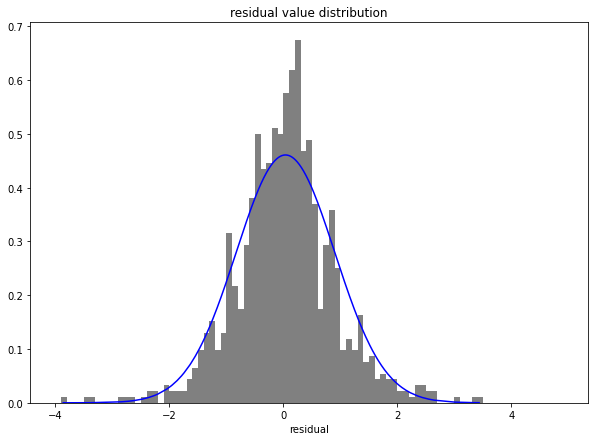

In [ ]:
plot_residual_distribution(X["dev"])

In [ ]:
from keras.layers import Dense, LSTM, Activation
from keras.utils.generic_utils import get_custom_objects
from keras.regularizers import l1_l2
from keras import backend as K

class Double_Tanh(Activation):
    def __init__(self, activation, **kwargs):
        super(Double_Tanh, self).__init__(activation, **kwargs)
        self.__name__ = 'double_tanh'

def double_tanh(x):
    return (K.tanh(x) * 2)

get_custom_objects().update({'double_tanh':Double_Tanh(double_tanh)})

In [ ]:
n_steps=X["train"].shape[1]
n_features=X["train"].shape[2]

model=Sequential()
model.add(SimpleRNN(100,activation='relu',return_sequences=True,recurrent_dropout=0.4,
                    input_shape=(n_steps, n_features),kernel_regularizer=l1_l2(0,0.1), bias_regularizer=l1_l2(0,0.1)))
model.add(TimeDistributed(Dropout(0.3)))
model.add(LSTM(n_features))
model.add(Activation(double_tanh))
#model.add(tf.keras.layers.Lambda(lambda x: x * 2))
#model.add(Dense(n_features,activation="tanh"))
model.compile(optimizer='adam', loss="mse", metrics=["mse"])
history=model.fit(X["train"], y["train"], epochs=50, batch_size=3,verbose=1,validation_data=(X["dev"],y["dev"]))
val_loss=history.history['val_loss']
loss=history.history['loss']

epochs=range(len(loss))
plt.figure(figsize=(15,7))
plt.plot(epochs, val_loss, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["val_loss", "Loss"])


In [ ]:
X_train,y_train,X_dev,y_dev=X["train"],y["train"],X["dev"],y["dev"]

X_train=np.reshape(X_train,(-1,X_train.shape[1],1))
X_dev=np.reshape(X_dev,(-1,X_dev.shape[1],1))
y_train=np.reshape(y_train,(-1,))
y_dev=np.reshape(y_dev,(-1,))

print(y_train.shape)

(1242,)


In [ ]:
n_steps=X_train.shape[1]
n_features=1

model=Sequential()
model.add(SimpleRNN(30,activation="relu",recurrent_dropout=0.6,input_shape=(n_steps, n_features)))
#model.add(TimeDistributed(Dropout(0.4)))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation(double_tanh))
model.compile(optimizer="rmsprop",loss="mse")

history=model.fit(X_train,y_train,epochs=10,batch_size=1,validation_data=(X_dev,y_dev))

val_loss=history.history['val_loss']
loss=history.history['loss']

epochs=range(len(loss))
plt.figure(figsize=(15,7))
plt.plot(epochs, val_loss, 'r')
#plt.plot(epochs, loss, 'b')
plt.title('Validation and Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Validation", "Train"])


In [ ]:
X_test=X["test"]
#X_test=np.reshape(X_test,(-1,X_train.shape[1],1))
Residual_pred=np.reshape(model.predict(X_test),(-1,))
Residual_pred.shape
pc_pred=np.add(y["ARIMA forecast"],Residual_pred)
ones=np.ones(pc_pred.size)
ones=np.ones(pc_pred.size)
filt_1=np.maximum(P_Corr_pred,-ones)
filt_2=np.maximum(-filt_1,-ones)
final=-filt_2
#filt_2=np.min(filt_1,)

In [ ]:
def rolling_pc(df,sliding_window_size):
    new_data=[]
    columns=list(df.columns)
    for i in range(int(len(df)/sliding_window_size)):
        end=-(sliding_window_size)*i
        start=-(sliding_window_size)*(i+1)
        if i==0:
             extract=df.iloc[start:].copy()
        else:     
            extract=df.iloc[start:end].copy()
        #print(f"start: {start} end:{end} ")
        pcorr_vec=[]
        #print("~"*5+str(i)+"~"*5)
        for j in range(len(df.columns)-1):
            covar=list(set(columns[:-1]).difference({columns[j]}))
           # print("   "+columns[j]+" "+columns[-1])
            p_cor=pg.partial_corr(data=extract, x=columns[j], y=columns[-1], covar=covar, method='pearson').round(3)
            pcorr_vec.append(float(p_cor["r"]))
        new_data.append(pcorr_vec)
    new_data.reverse()    
    PCor_dataset=pd.DataFrame(np.array(new_data),columns=columns[:-1])
    return PCor_dataset

In [ ]:
test_data=df.iloc[450:450+30].copy()
post=rolling_pc(test_data,30)



```
Price_1   :::::   ARIMA model order:(0, 2, 1)
Price_2   :::::   ARIMA model order:(0, 2, 1)
Price_3   :::::   ARIMA model order:(0, 2, 1)
Price_4   :::::   ARIMA model order:(0, 2, 1)
Price_5   :::::   ARIMA model order:(0, 2, 1)
Price_7   :::::   ARIMA model order:(1, 1, 1)
Price_8   :::::   ARIMA model order:(1, 2, 1)
Price_9   :::::   ARIMA model order:(0, 0, 0)
Price_11   :::::   ARIMA model order:(0, 2, 0)
Price_12   :::::   ARIMA model order:(1, 1, 1)
Price_14   :::::   ARIMA model order:(0, 2, 1)
Price_15   :::::   ARIMA model order:(0, 1, 1)
Price_16   :::::   ARIMA model order:(3, 2, 0)
Price_17   :::::   ARIMA model order:(1, 2, 1)
Price_18   :::::   ARIMA model order:(0, 2, 1)
Price_19   :::::   ARIMA model order:(0, 2, 1)
Price_20   :::::   ARIMA model order:(1, 2, 1)
Price_21   :::::   ARIMA model order:(0, 1, 1)
Price_22   :::::   ARIMA model order:(1, 2, 1)
Price_23   :::::   ARIMA model order:(1, 2, 1)
Price_24   :::::   ARIMA model order:(0, 2, 1)
Price_26   :::::   ARIMA model order:(0, 2, 1)
Price_27   :::::   ARIMA model order:(0, 2, 0)
Price_28   :::::   ARIMA model order:(0, 2, 1)
Price_29   :::::   ARIMA model order:(0, 2, 1)
Price_30   :::::   ARIMA model order:(0, 0, 0)
Price_31   :::::   ARIMA model order:(0, 1, 0)
Price_32   :::::   ARIMA model order:(1, 2, 1)
Price_33   :::::   ARIMA model order:(2, 0, 1)
Price_34   :::::   ARIMA model order:(1, 2, 1)
Price_35   :::::   ARIMA model order:(0, 2, 1)
Price_36   :::::   ARIMA model order:(2, 2, 0)
Price_37   :::::   ARIMA model order:(0, 2, 1)
Price_38   :::::   ARIMA model order:(0, 1, 1)
Price_39   :::::   ARIMA model order:(1, 2, 1)
Price_40   :::::   ARIMA model order:(0, 0, 0)
Price_41   :::::   ARIMA model order:(0, 0, 0)
Price_42   :::::   ARIMA model order:(0, 2, 1)
Price_43   :::::   ARIMA model order:(0, 1, 0)
Price_44   :::::   ARIMA model order:(0, 2, 0)
Price_45   :::::   ARIMA model order:(0, 2, 0)
Price_46   :::::   ARIMA model order:(2, 2, 1)
Price_47   :::::   ARIMA model order:(1, 2, 1)
Price_48   :::::   ARIMA model order:(0, 1, 1)
Price_49   :::::   ARIMA model order:(0, 2, 1)
Price_50   :::::   ARIMA model order:(0, 2, 0)

```



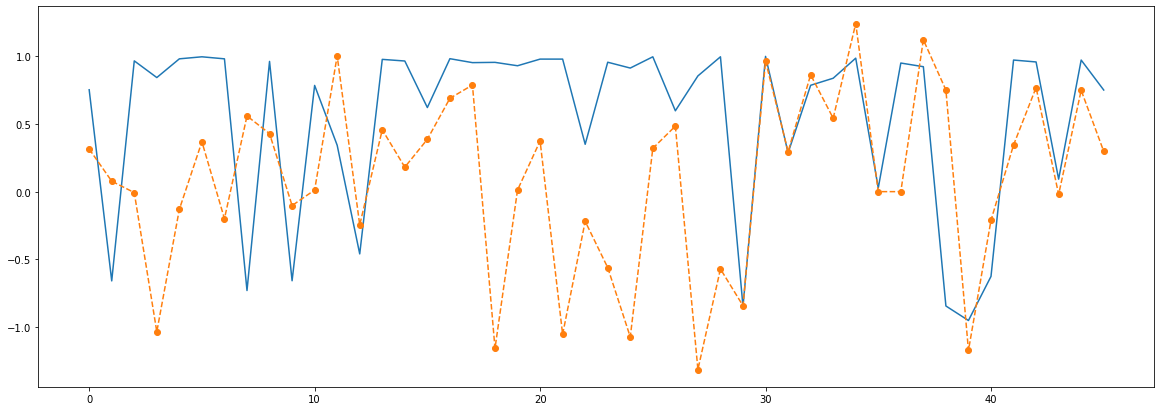

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(np.array(post.iloc[0]),label="Actual")
plt.plot(y["ARIMA forecast"],"--o",label="Linear part")

In [ ]:
np.average(post,axis=0)

array([-0.0015, -0.1765, -0.068 ,  0.2305,  0.4035,  0.1575,  0.561 ,
        0.691 , -0.1755,  0.0865, -0.311 ,  0.5245,  0.489 ,  0.441 ,
        0.1185,  0.1705,  0.3305,  0.703 , -0.6625,  0.7065,  0.893 ,
       -0.4985,  0.6255,  0.7425,  0.4815,  0.0985,  0.558 ,  0.4145,
        0.64  ,  0.093 , -0.079 ,  0.0225,  0.7245,  0.0385,  0.5105,
        0.0115,  0.58  ,  0.747 ,  0.934 ,  0.286 , -0.0835,  0.6615,
        0.7005,  0.6115,  0.2955,  0.122 ])

In [ ]:
np.array(post.iloc[0])

array([ 0.751, -0.658,  0.964,  0.841,  0.979,  0.994,  0.979, -0.729,
        0.96 , -0.657,  0.783,  0.342, -0.459,  0.975,  0.963,  0.62 ,
        0.98 ,  0.951,  0.953,  0.928,  0.977,  0.977,  0.349,  0.954,
        0.911,  0.994,  0.596,  0.853,  0.994, -0.847,  0.997,  0.286,
        0.784,  0.836,  0.984,  0.027,  0.948,  0.921, -0.843, -0.95 ,
       -0.625,  0.97 ,  0.956,  0.092,  0.97 ,  0.749])

In [ ]:
np.array(y["Arima forecast"])

KeyError: ignored

In [ ]:
np.average(post,axis=0)-y["ARIMA forecast"]

array([-0.14312799,  0.1165    ,  0.94750257, -1.58876109,  1.59180019,
        0.53546738,  1.0452266 ,  1.90474354, -0.01909893, -0.6484608 ,
       -0.73942018,  0.4825    , -0.72317755,  0.20840319,  0.1575    ,
        0.1563698 ,  0.0188    ,  1.71779868, -1.63695837,  0.8266948 ,
       -0.17660975, -0.13024051,  0.177     ,  0.36566015,  0.58029579,
       -0.50090903, -0.55325196, -0.14916925,  0.28396969,  1.02506364,
       -1.4216576 ,  0.63828183,  1.3375    , -0.34403346,  1.15011081,
       -0.56795161,  1.292     ,  0.69175063,  0.09725638,  1.762     ,
       -0.34619836,  0.3916    ,  0.00525421, -0.87493741,  1.16348853,
        0.87516273])

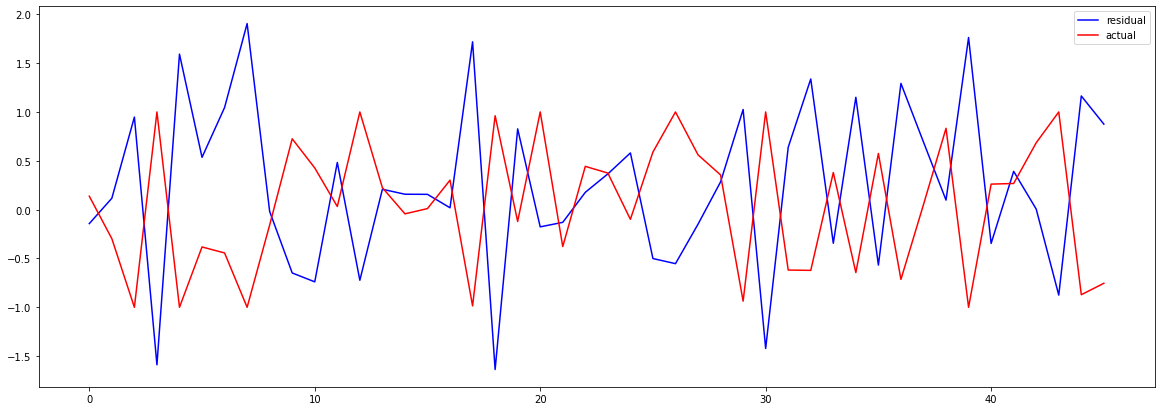

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(np.average(post,axis=0)-y["ARIMA forecast"],'blue',label="residual")
plt.plot(final,'red',label="actual")
plt.legend()

In [ ]:
'''
data_matrix = []

for i in range(len(new_assets)):
    for j in range(len(new_assets)-1-i):
        a = new_assets[i]
        b = new_assets[9-j]
        corr_series = rolling_corr(a,b)[99:]
        corr_strided = list(corr_series[[100*k for k in range(24)]])
        data_matrix.append(corr_strided)

data_dictionary = {}
for i in range(len(data_matrix)):
    data_dictionary[str(i)] = data_matrix[i]
data_df = pd.DataFrame(data_dictionary)

before_arima_dataset = []
for i in range(45):
    before_arima_dataset.append(data_df[str(i)][:21])
    before_arima_dataset.append(data_df[str(i)][1:22])
    before_arima_dataset.append(data_df[str(i)][2:23])
    before_arima_dataset.append(data_df[str(i)][3:])
before_arima_dataset = pd.DataFrame(np.array(before_arima_dataset))
before_arima_dataset.shape
#before_arima_dataset
#before_arima_dataset.to_csv('C:/Users/Froilan/Desktop/myFiles/JupyterFiles/stock_correlation_prediction/train_dev_test/new_asset_before_arima.csv')
'''

In [ ]:
'''
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

train=PCor_dataset[:48]
#train = np.transpose(train.loc[:, ~train.columns.str.contains('^Unnamed')])
for _ in range(5):
    
    randint = random.randrange(0,46,1)
    print(columns[randint])
    train[columns[randint]].plot()
    plt.show()
    plt.close()
    plot_acf(train[columns[randint]])
    plt.show()
    plt.close()
    plot_pacf(train[columns[randint]])
    plt.show()
    plt.close()
    print('----------------------------------------------------')
'''    

In [ ]:
test=pd.DataFrame(np.array(pre_ARIMA_data.iloc[-window_size:].copy()),columns=pre_ARIMA_data.columns)
forecast=[]
residuals=[]
for i in range(len(test.columns)):
        data=test[test.columns[i]]
        kpss_diffs = ndiffs(data, alpha=0.01, test='kpss', max_d=2)
        adf_diffs = ndiffs(data, alpha=0.01, test='adf', max_d=2)
        n_diffs = max(adf_diffs, kpss_diffs)

        #print(f"Estimated differencing term: {n_diffs}")
        model = pm.auto_arima(data, d=n_diffs, seasonal=False, stepwise=True, suppress_warnings=True, information_criterion='aic', error_action="ignore", max_p=6, max_order=None, trace=False)
        print(f"{df.columns[i]}   :::::   ARIMA model order:{model.order}")
        pred = list(model.predict_in_sample())
        fcast=model.predict(1)
        forecast.append(fcast)
        resid=list(data-pred)
        residuals.append(resid)
Residuals=pd.DataFrame(np.around(np.array(residuals).T,3),columns=test.columns)
X_test=Residuals
ARIMA_forecast=np.reshape(np.array(forecast),(-1,))
plt.plot(forecast)